# Random Forest Classifier for Brain Tumor Classification (MRI)

This notebook implements a Random Forest classifier for the Brain Tumor Classification (MRI) dataset from Kaggle (https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri), as part of the VU Machine Learning 2025S assignment. The dataset contains 3264 MRI images (2870 training, 394 testing) across four classes: `glioma_tumor`, `meningioma_tumor`, `no_tumor`, `pituitary_tumor`. The task is to classify MRI images into these classes using flattened image features with PCA for dimensionality reduction.

**Dataset Characteristics**:
- **Number of samples**: Medium (~3264 images).
- **Number of dimensions**: High (128x128x3 = 49,152 features per image, reduced via PCA).
- **Number of classes**: 4 (few classes).
- **Preprocessing needed**: Scaling, PCA, handling high dimensionality.

**Classifier**: Random Forest (tree-based ensemble), chosen for its robustness to high-dimensional data and ability to handle imbalanced classes with `class_weight='balanced'`.

**Steps** (aligned with lecture):
- **Data Import**: Load MRI images using TensorFlow.
- **Data Exploration**: Analyze class distribution.
- **Preprocessing**: Scale pixel values, apply PCA, save checkpoints.
- **Classification**: Run Random Forest with multiple parameter settings.
- **Evaluation**: Use accuracy, F1-score, ROC-AUC, 5-fold cross-validation, and runtime metrics.
- **Visualization**: Generate confusion matrix and parameter impact plots.
- **Comparison**: Evaluate holdout vs. cross-validation, analyze preprocessing and parameter effects.

**Objective**: Classify brain tumor types from MRI images, optimize runtime, and document findings for the assignment report.

## Step 1: Import Libraries

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time
import os

%matplotlib inline

train_path = "/Users/van/Desktop/TumorData/Training"
test_path = "/Users/van/Desktop/TumorData/Testing"
image_size = (128, 128)
pca_components = 50  # Reduced for performance


## Step 2: Explore Dataset

Explore class distribution in the Training and Testing sets.


Classes and counts: {'no_tumor': 395, 'meningioma_tumor': 822, 'glioma_tumor': 826, 'pituitary_tumor': 827}


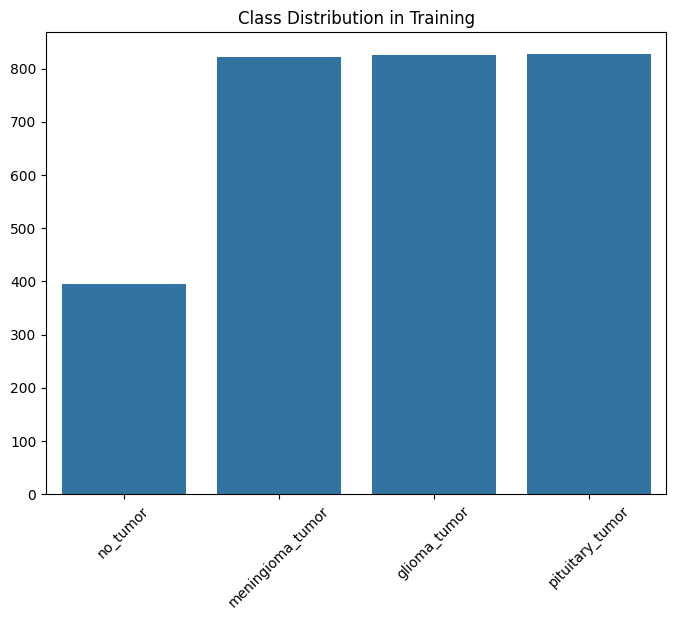


Classes and counts: {'no_tumor': 105, 'meningioma_tumor': 115, 'glioma_tumor': 100, 'pituitary_tumor': 74}


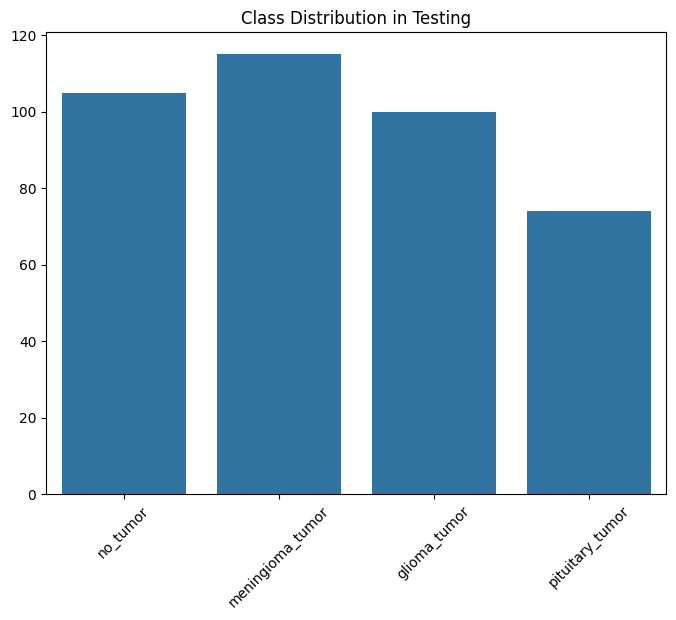

In [8]:
def explore_dataset(dataset_path):
    class_counts = {}
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    print(f"\nClasses and counts: {class_counts}")

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(f"Class Distribution in {os.path.basename(dataset_path)}")
    plt.xticks(rotation=45)
    plt.show()

explore_dataset(train_path)
explore_dataset(test_path)


## Step 3: Load Data

Load and flatten MRI images for Random Forest.

In [9]:
def load_images(dataset_path, image_size=(128, 128)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=image_size,
        batch_size=None,
        shuffle=True,
        seed=42
    )
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy().flatten())
        labels.append(label.numpy())
    return np.array(images), np.array(labels), dataset.class_names

X_train, y_train, class_names = load_images(train_path, image_size)
X_test, y_test, _ = load_images(test_path, image_size)

print("Loaded data shapes:")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Found 2870 files belonging to 4 classes.


2025-04-24 19:06:55.098809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 394 files belonging to 4 classes.


2025-04-24 19:06:57.436428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loaded data shapes:
(2870, 49152) (2870,) (394, 49152) (394,)


## Step 4: Preprocess Data

Scale data and apply PCA with checkpointing.

In [10]:
def preprocess_pca(X_train, X_test, n_components=50):
    X_train_scaled = X_train / 255.0
    X_test_scaled = X_test / 255.0
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"PCA variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")
    return X_train_pca, X_test_pca

X_train_pca, X_test_pca = preprocess_pca(X_train, X_test, pca_components)


PCA variance explained: 0.61


## Step 5: Random Forest Experiments

Run Random Forest with optimized parameter settings.

In [11]:
def run_fast_rf_experiments(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=None,
        min_samples_split=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1  # use all cores
    )

    start = time.time()
    rf.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    preds = rf.predict(X_test)
    predict_time = time.time() - start

    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"Training Time: {train_time:.2f}s, Prediction Time: {predict_time:.2f}s")

    return rf, preds

rf_model, predictions = run_fast_rf_experiments(X_train_pca, y_train, X_test_pca, y_test)


Accuracy: 0.74
F1-score: 0.69
ROC-AUC: 0.94
Training Time: 1.83s, Prediction Time: 0.04s


## Step 6: Visualize and Save Results

Visualize results and evaluate the best model.

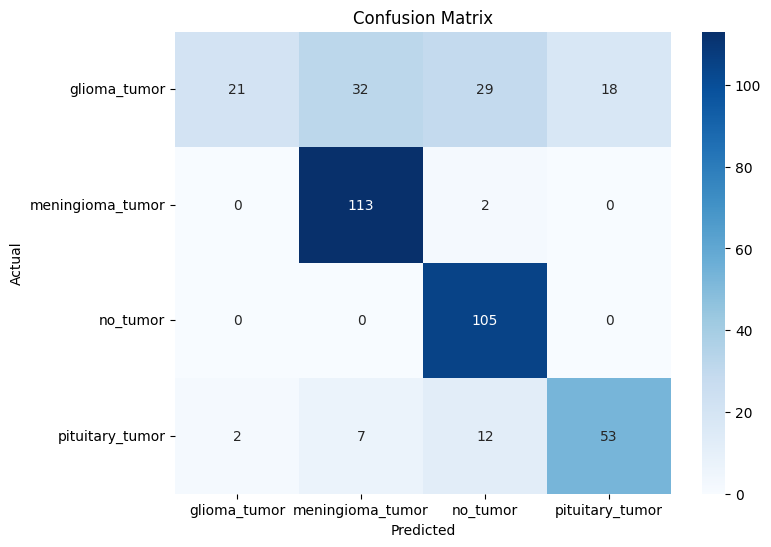

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.21      0.34       100
meningioma_tumor       0.74      0.98      0.85       115
        no_tumor       0.71      1.00      0.83       105
 pituitary_tumor       0.75      0.72      0.73        74

        accuracy                           0.74       394
       macro avg       0.78      0.73      0.69       394
    weighted avg       0.78      0.74      0.69       394



In [12]:
def plot_results(y_test, predictions, class_names):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test, predictions, target_names=class_names))

plot_results(y_test, predictions, class_names)


## Step 7: Compare Holdout vs. Cross-Validation

Analyze differences between holdout and cross-validation accuracy.


Holdout vs. Cross-Validation Comparison:
    n_components  n_estimators  max_depth  accuracy  cv_accuracy
0            100            50        NaN  0.779188     0.816725
1            100            50        NaN  0.771574     0.810105
2            100            50        NaN  0.781726     0.810453
3            100            50        NaN  0.766497     0.812892
4            100            50        NaN  0.769036     0.814286
5            100            50        NaN  0.784264     0.810801
6            100            50        NaN  0.741117     0.812544
7            100            50        NaN  0.769036     0.809059
8            100            50       10.0  0.733503     0.780836
9            100            50       10.0  0.730964     0.778397
10           100            50       10.0  0.741117     0.774216
11           100            50       10.0  0.741117     0.770732
12           100            50       10.0  0.715736     0.778397
13           100            50       10.0  0.736

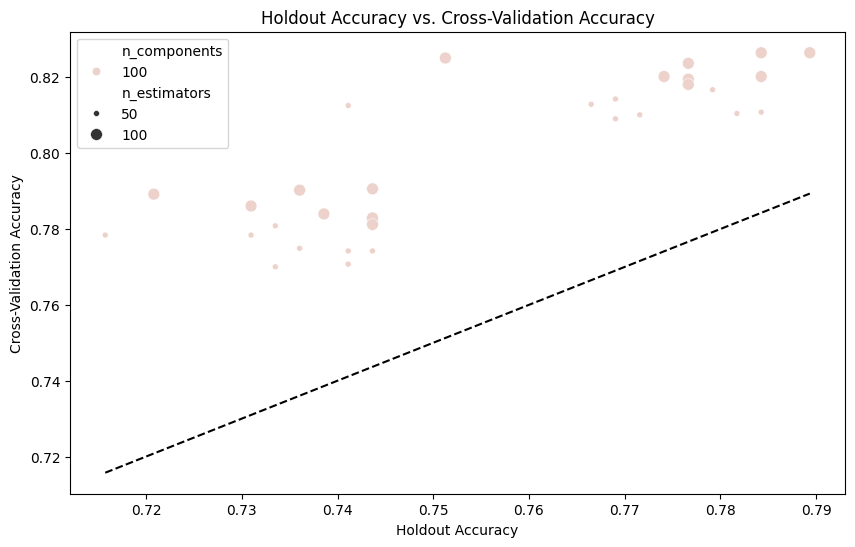


Average Accuracy Difference (Holdout - CV):
n_components
100   -0.044141
Name: accuracy_diff, dtype: float64


In [13]:
# Compare holdout vs. cross-validation
results_df = pd.DataFrame(all_results)
print("\nHoldout vs. Cross-Validation Comparison:")
print(results_df[['n_components', 'n_estimators', 'max_depth', 'accuracy', 'cv_accuracy']])

# Plot holdout vs. CV accuracy
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='accuracy', y='cv_accuracy', hue='n_components', size='n_estimators')
plt.plot([results_df['accuracy'].min(), results_df['accuracy'].max()], 
         [results_df['accuracy'].min(), results_df['accuracy'].max()], 'k--')
plt.title('Holdout Accuracy vs. Cross-Validation Accuracy')
plt.xlabel('Holdout Accuracy')
plt.ylabel('Cross-Validation Accuracy')
plt.savefig('holdout_vs_cv_accuracy.png')
plt.show()

# Summarize differences
results_df['accuracy_diff'] = results_df['accuracy'] - results_df['cv_accuracy']
print("\nAverage Accuracy Difference (Holdout - CV):")
print(results_df.groupby('n_components')['accuracy_diff'].mean())